# Diabetes Classification — Logistic Regression vs KNN

In [1]:
import os, warnings, json
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

plt.rcParams["figure.figsize"] = (12, 7)


In [3]:
CANDIDATE_PATHS = ["diabetes.csv", "diabetes.csv"]
for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        DATA_PATH = p
        break
else:
    raise FileNotFoundError("Could not find 'diabetes.csv'. Place it next to this notebook ")

df = pd.read_csv(DATA_PATH).copy()
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# ---- Overview & cleaning ----
print("Shape:", df.shape); display(df.info()); display(df.describe().T)

zero_cols = [c for c in ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"] if c in df.columns]
for c in zero_cols:
    df.loc[df[c] == 0, c] = np.nan
for c in zero_cols:
    df[c] = df[c].fillna(df[c].median())

print("Post-imputation missing (selected cols):")
display(df[zero_cols].isna().sum())


Shape: (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Post-imputation missing (selected cols):


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

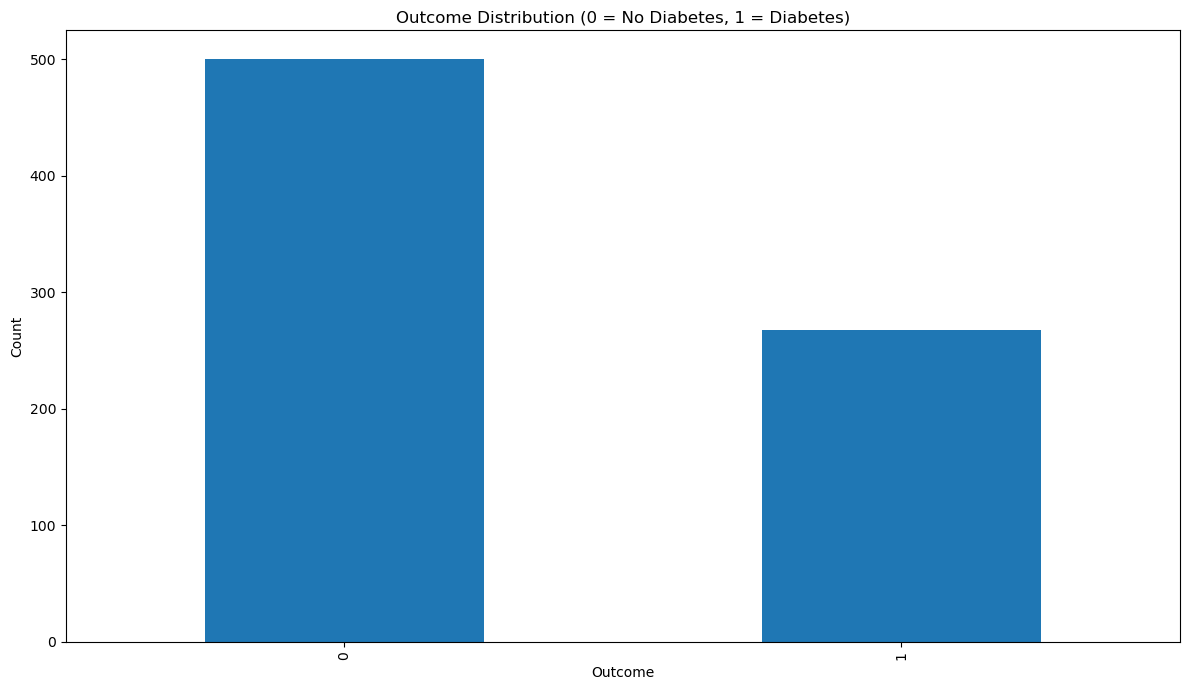

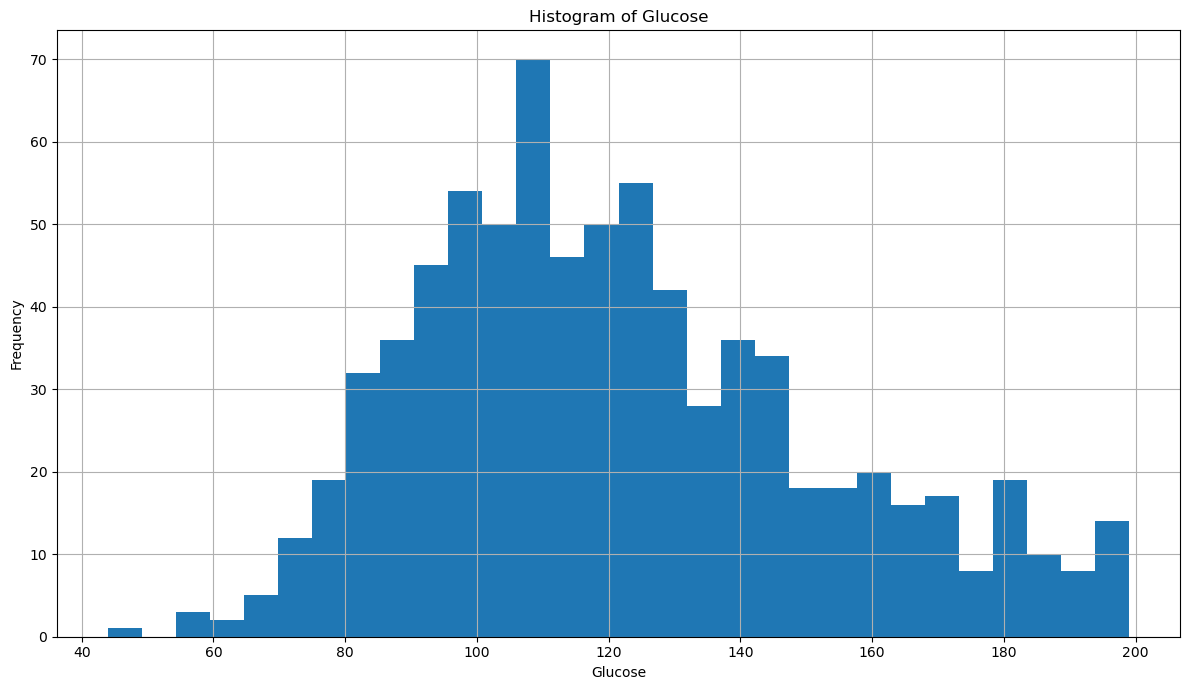

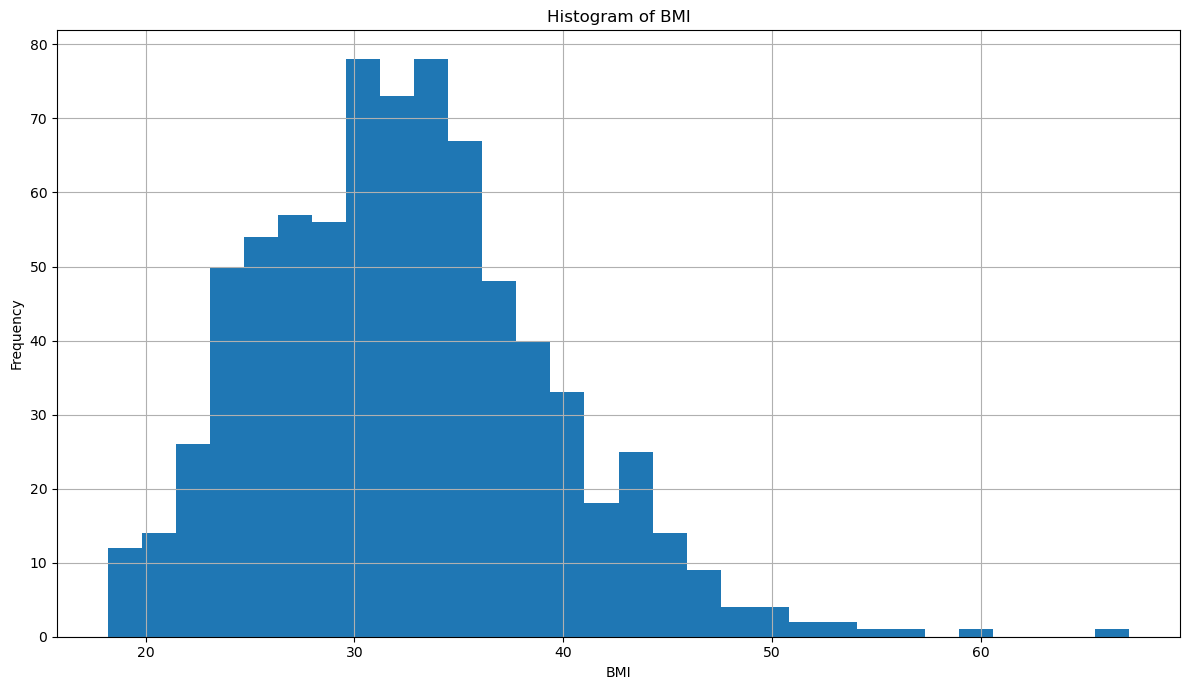

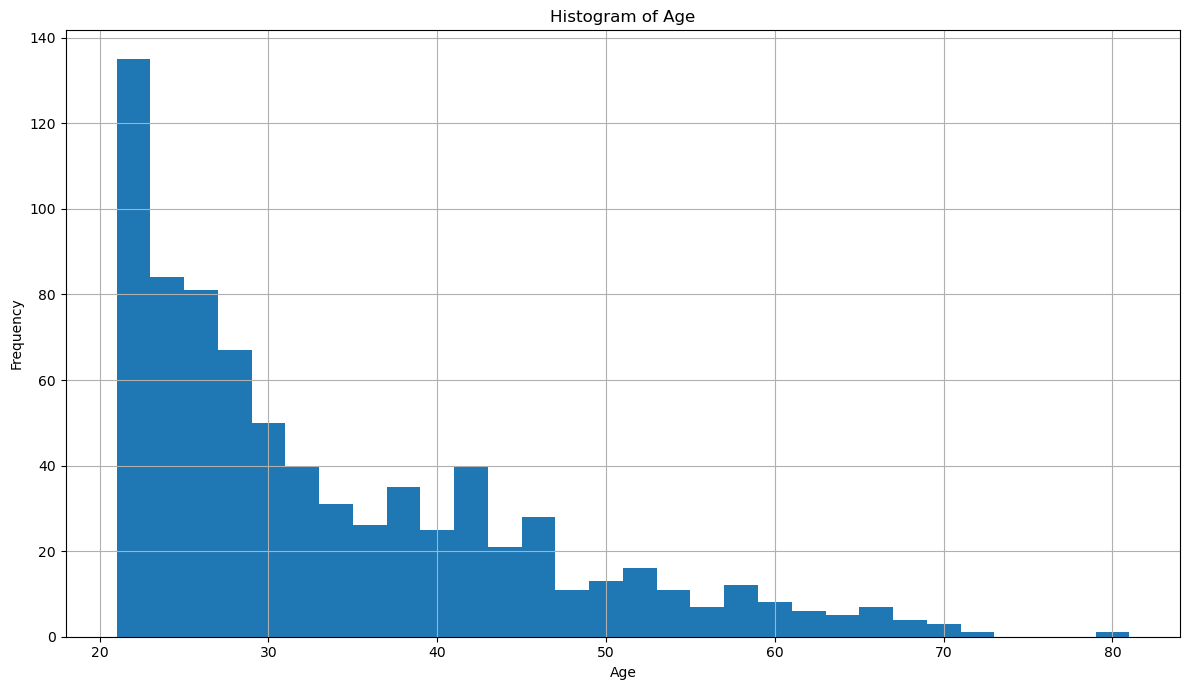

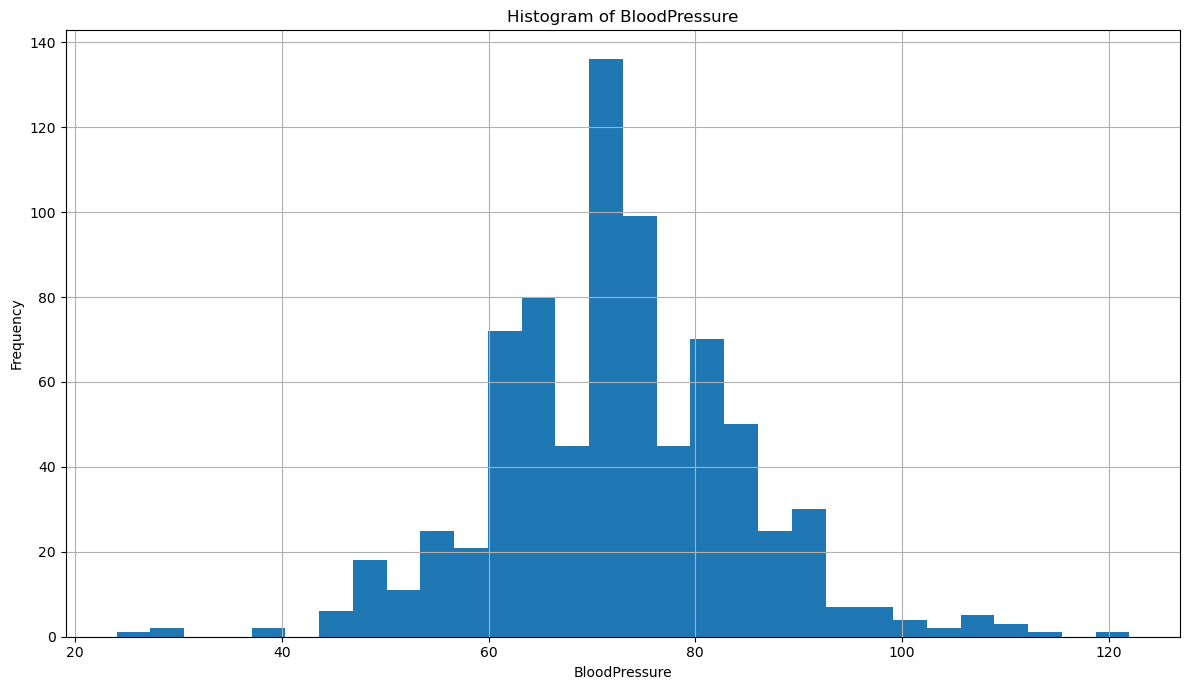

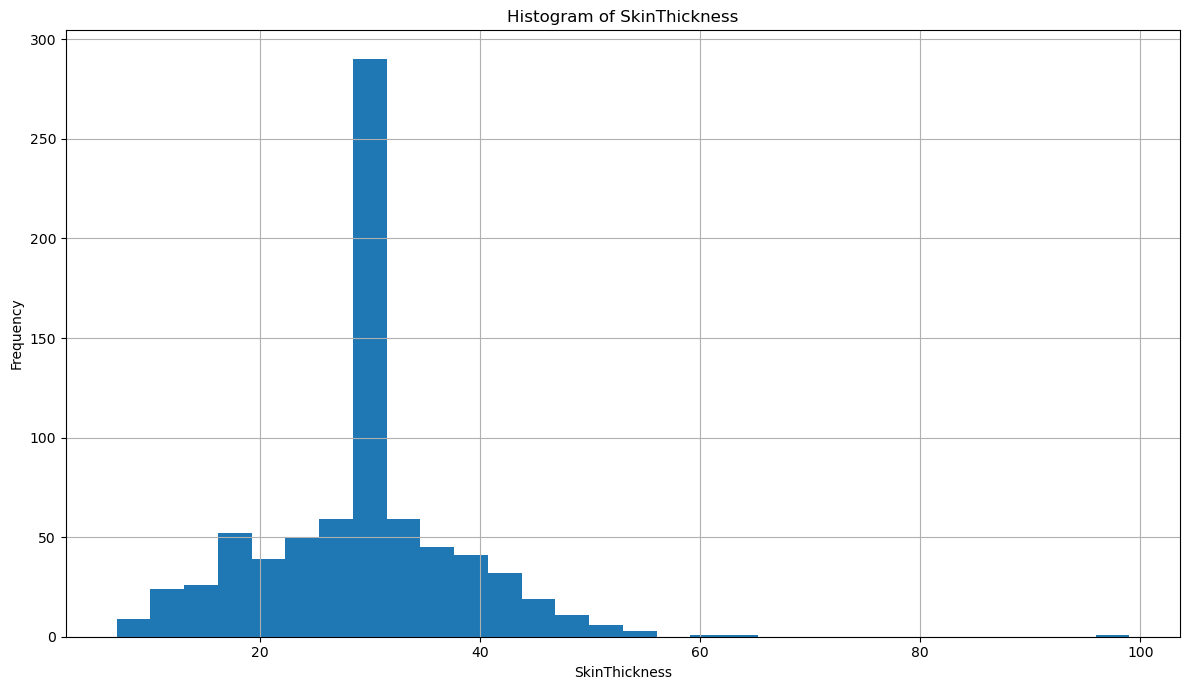

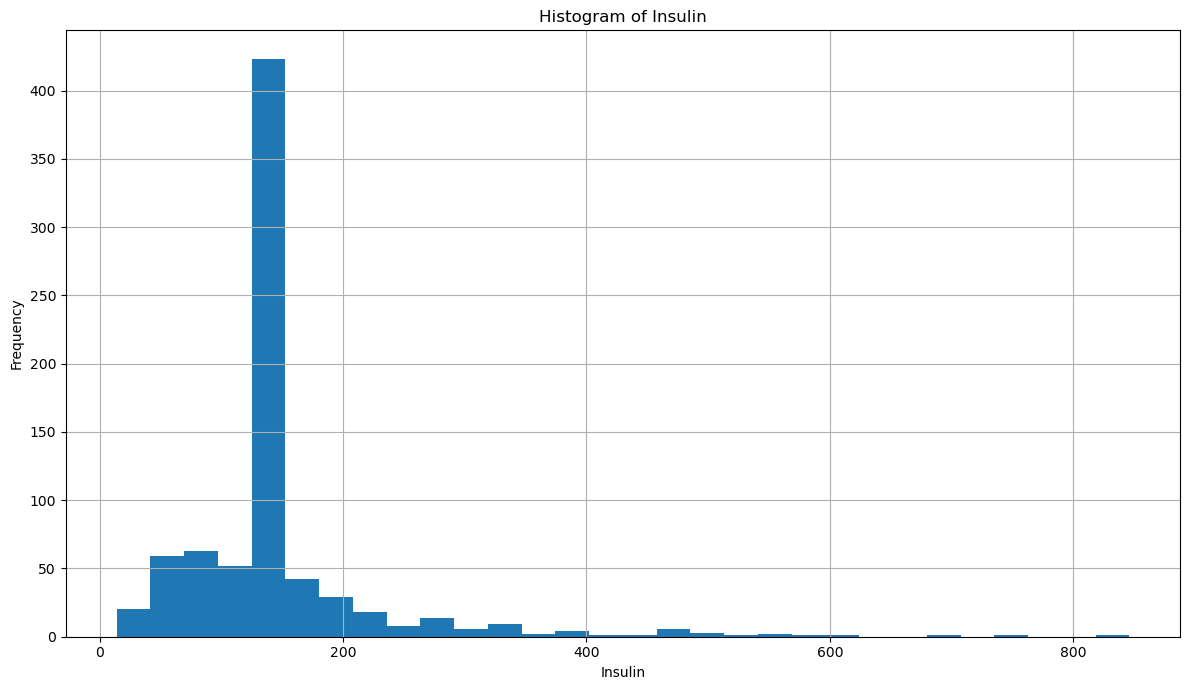

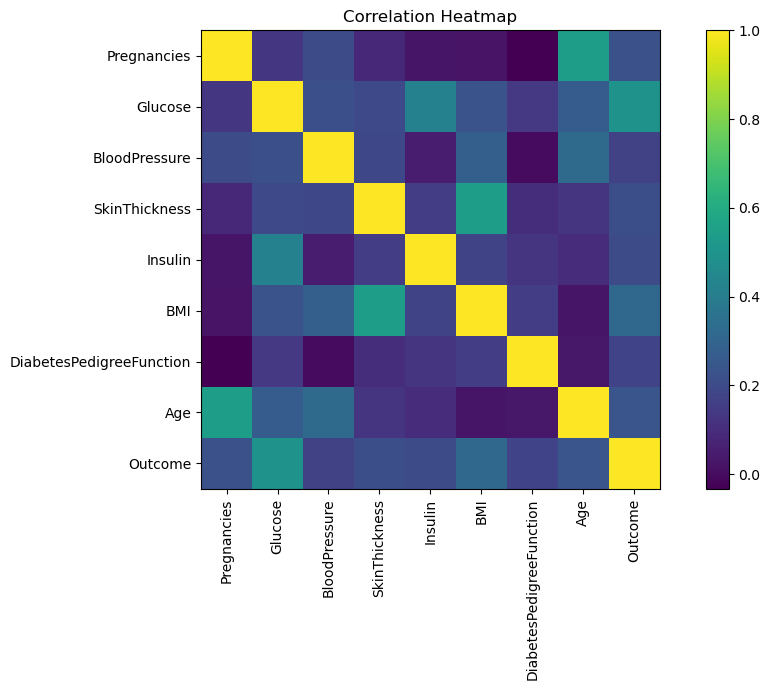

In [5]:
if "Outcome" in df.columns:
    vc = df["Outcome"].value_counts().sort_index()
    plt.figure(); vc.plot(kind="bar")
    plt.title("Outcome Distribution (0 = No Diabetes, 1 = Diabetes)")
    plt.xlabel("Outcome"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

for col in [c for c in ["Glucose","BMI","Age","BloodPressure","SkinThickness","Insulin"] if c in df.columns]:
    plt.figure(); df[col].hist(bins=30)
    plt.title(f"Histogram of {col}"); plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout(); plt.show()

import numpy as np
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr(numeric_only=True)
fig, ax = plt.subplots()
im = ax.imshow(corr.values)
ax.set_xticks(range(len(corr.columns))); ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90); ax.set_yticklabels(corr.columns)
plt.title("Correlation Heatmap"); plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()


In [7]:
# ---- Split ----
assert "Outcome" in df.columns, "Expected 'Outcome' target column not found."
X = df.drop(columns=["Outcome"]); y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (614, 8)  Test: (154, 8)


LR metrics: {
  "Model": "Logistic Regression",
  "Accuracy": 0.6948051948051948,
  "Precision (pos=1)": 0.574468085106383,
  "Recall (pos=1)": 0.5,
  "F1 (pos=1)": 0.5346534653465347
}

LR Classification Report:
               precision    recall  f1-score   support

           0      0.748     0.800     0.773       100
           1      0.574     0.500     0.535        54

    accuracy                          0.695       154
   macro avg      0.661     0.650     0.654       154
weighted avg      0.687     0.695     0.689       154



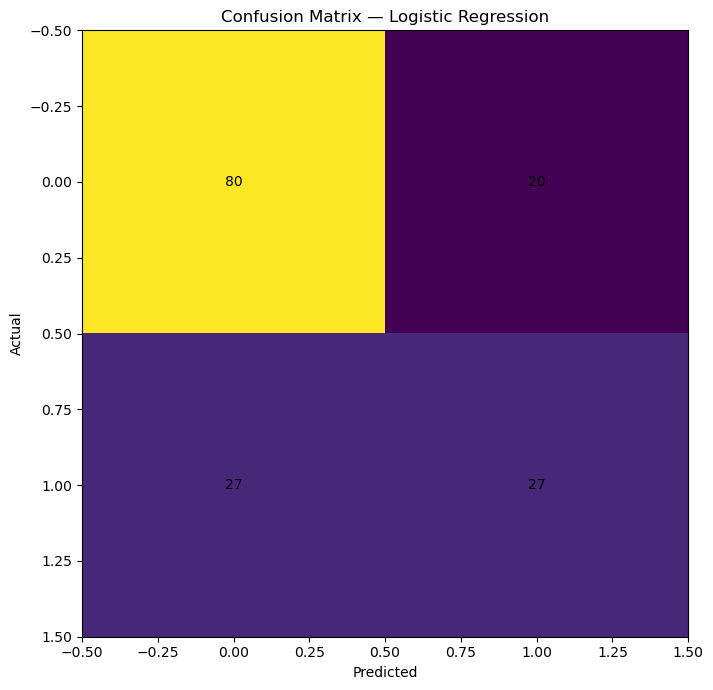

In [8]:
# ---- Logistic Regression ----
log_reg_pipe = Pipeline([("scaler", StandardScaler()), ("model", LogisticRegression(max_iter=1000, solver="liblinear"))])
log_reg_pipe.fit(X_train, y_train)
y_pred_lr = log_reg_pipe.predict(X_test)

lr_metrics = {
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision (pos=1)": precision_score(y_test, y_pred_lr, pos_label=1),
    "Recall (pos=1)": recall_score(y_test, y_pred_lr, pos_label=1),
    "F1 (pos=1)": f1_score(y_test, y_pred_lr, pos_label=1),
}
print("LR metrics:", json.dumps(lr_metrics, indent=2))
print("\nLR Classification Report:\n", classification_report(y_test, y_pred_lr, digits=3))

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(); plt.imshow(cm_lr); plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        plt.text(j, i, cm_lr[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()


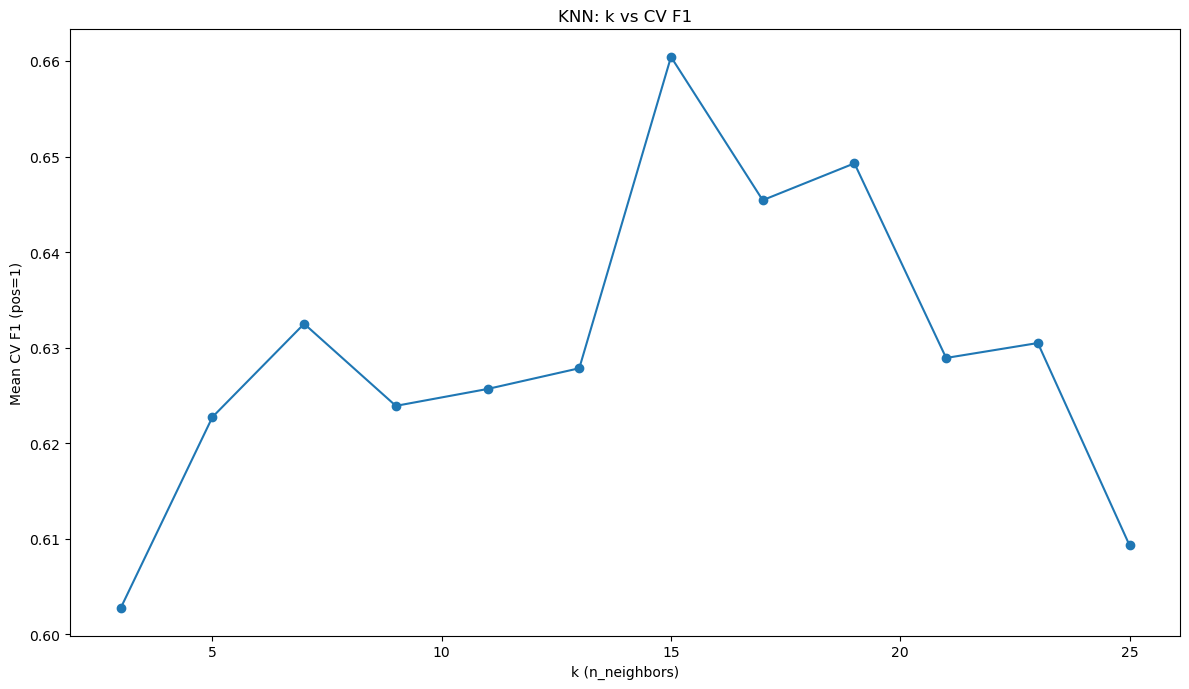

KNN metrics: {
  "Model": "KNN (k=15)",
  "Accuracy": 0.7402597402597403,
  "Precision (pos=1)": 0.6521739130434783,
  "Recall (pos=1)": 0.5555555555555556,
  "F1 (pos=1)": 0.6
}

KNN Classification Report:
               precision    recall  f1-score   support

           0      0.778     0.840     0.808       100
           1      0.652     0.556     0.600        54

    accuracy                          0.740       154
   macro avg      0.715     0.698     0.704       154
weighted avg      0.734     0.740     0.735       154



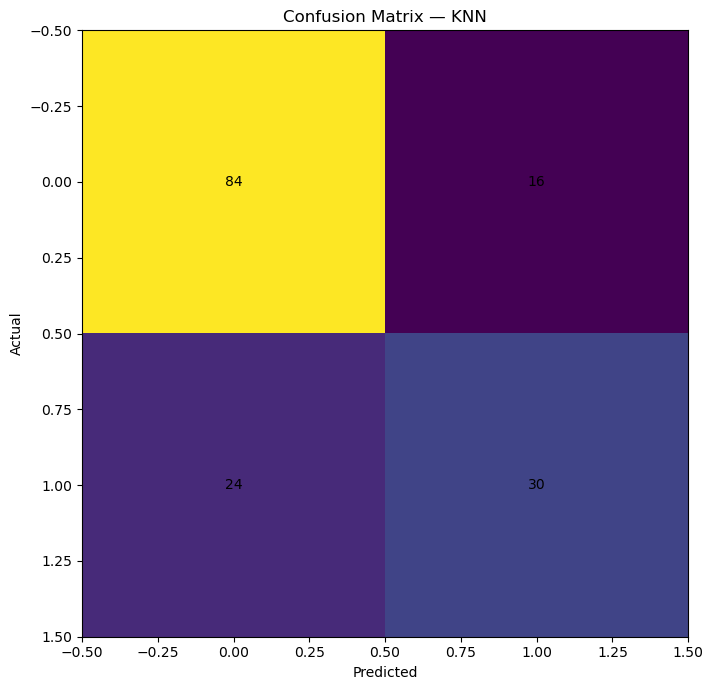

In [9]:
# ---- KNN with CV for k ----
knn_pipe = Pipeline([("scaler", StandardScaler()), ("model", KNeighborsClassifier())])
param_grid = {"model__n_neighbors": list(range(3, 26, 2))}
grid = GridSearchCV(knn_pipe, param_grid, scoring="f1", cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_knn = grid.best_estimator_

k_vals = [p["model__n_neighbors"] for p in grid.cv_results_["params"]]
mean_scores = grid.cv_results_["mean_test_score"]
plt.figure(); plt.plot(k_vals, mean_scores, marker="o")
plt.xlabel("k (n_neighbors)"); plt.ylabel("Mean CV F1 (pos=1)"); plt.title("KNN: k vs CV F1")
plt.tight_layout(); plt.show()

y_pred_knn = best_knn.predict(X_test)
knn_metrics = {
    "Model": f"KNN (k={best_knn.get_params()['model__n_neighbors']})",
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision (pos=1)": precision_score(y_test, y_pred_knn, pos_label=1),
    "Recall (pos=1)": recall_score(y_test, y_pred_knn, pos_label=1),
    "F1 (pos=1)": f1_score(y_test, y_pred_knn, pos_label=1),
}
print("KNN metrics:", json.dumps(knn_metrics, indent=2))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred_knn, digits=3))

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(); plt.imshow(cm_knn); plt.title("Confusion Matrix — KNN")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for i in range(cm_knn.shape[0]):
    for j in range(cm_knn.shape[1]):
        plt.text(j, i, cm_knn[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()


In [10]:
# ---- Comparison & Summary ----
results_df = pd.DataFrame([lr_metrics, knn_metrics]).sort_values("F1 (pos=1)", ascending=False).reset_index(drop=True)
display(results_df)

best = results_df.iloc[0].to_dict()
print("Best model:", best["Model"])
print("Accuracy=%.3f  Precision=%.3f  Recall=%.3f  F1=%.3f" % (best["Accuracy"], best["Precision (pos=1)"], best["Recall (pos=1)"], best["F1 (pos=1)"]))

print("""
Why one may perform better:
• Logistic Regression assumes a linear relationship in log-odds; it is simple, robust, and interpretable.
• KNN is non-parametric and can capture non-linear patterns but is sensitive to feature scaling and noisy features.
• If decision boundary is mostly linear and data has some noise/outliers, LR often wins. If patterns are local and non-linear, tuned KNN can win.
""")


,Model,Accuracy,Precision (pos=1),Recall (pos=1),F1 (pos=1)
0,KNN (k=15),0.740260,0.652174,0.555556,0.600000
1,Logistic Regression,0.694805,0.574468,0.500000,0.534653


Best model: KNN (k=15)
Accuracy=0.740  Precision=0.652  Recall=0.556  F1=0.600

Why one may perform better:
• Logistic Regression assumes a linear relationship in log-odds; it is simple, robust, and interpretable.
• KNN is non-parametric and can capture non-linear patterns but is sensitive to feature scaling and noisy features.
• If decision boundary is mostly linear and data has some noise/outliers, LR often wins. If patterns are local and non-linear, tuned KNN can win.

